In [1]:
import os
import torch
import torchvision
from torch import nn, optim
from torchvision import transforms, models, datasets
!pip install torchsummary
from torchsummary import summary
from PIL import Image
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class NPZDataset(Dataset):
    def __init__(self, path, csv, transform=None):
        self.path = path
        self.water_indexes = pd.read_csv(csv)
        self.files = list(Path(path).glob('*.npz'))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        sat_img = np.load(str(self.files[idx]))['x'][-1]
        torch_array = torch.from_numpy(sat_img)
        if self.transform is not None:
            torch_array = self.transform(torch_array)
        y = self.water_indexes.iloc[idx, 8]
        y = torch.tensor(y, dtype=torch.float64)
        return torch_array, y

In [3]:
class TestNPZDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.files = list(Path(path).glob('*.npz'))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        numpy_array = np.load(str(self.files[idx]))['x']
        sat_img = np.moveaxis(numpy_array, 0, -1)[:, :, 2:5].transpose((-1, 0, 1))
        torch_array = torch.from_numpy(sat_img)
        if self.transform is not None:
            torch_array = self.transform(torch_array)
        return torch_array

In [9]:
train_dir = "/kaggle/input/bizinnovate-2023/dhs_train"
train_y = "/kaggle/input/bizinnovate-2023/train.csv"
valid_dir = "/kaggle/input/bizinnovate-2023/dhs_test"

train_data = NPZDataset(train_dir, train_y)
train_loader = DataLoader(train_data, batch_size=1000)

valid_data = TestNPZDataset(valid_dir)
valid_loader = DataLoader(valid_data, batch_size=1000, shuffle=True)

In [26]:
imgs, labs = next(iter(train_loader))

In [9]:
imgs.shape

torch.Size([1000, 255, 255])

In [10]:
v_min, v_max = imgs.squeeze().min(), imgs.squeeze().max()
new_min, new_max = -1, 1

In [11]:
v_p = (imgs - v_min)/(v_max - v_min)*(new_max - new_min) + new_min
v_p.shape

torch.Size([1000, 255, 255])

In [12]:
torch.min(v_p.squeeze())

tensor(-1.)

In [13]:
torch.max(v_p.squeeze())

tensor(1.)

In [43]:
q1 = np.zeros(len(train_data))
q2 = np.zeros(len(train_data))
q3 = np.zeros(len(train_data))
q4 = np.zeros(len(train_data))
not_water = np.zeros(len(train_data))

i = 0
for X, y in train_loader:
    v_min, v_max = X.squeeze().min(), X.squeeze().max()
    new_min, new_max = -1, 1
    
    # normalize
    norm_X = (X - v_min)/(v_max - v_min)*(new_max - new_min) + new_min
    
    for img in norm_X:
        # calculate proportions
        q1[i] = torch.numel(img[img <= -0.99]) / (255*255)
        q2[i] = torch.numel(img[(img > -0.99) & (img <= -0.90)]) / (255*255)
        q3[i] = torch.numel(img[(img > -0.90) & (img <= -0.80)]) / (255*255)
        q4[i] = torch.numel(img[(img > -0.80) & (img <= 0.015)]) / (255*255)
        not_water[i] = torch.numel(img[img > 0.015]) / (255*255)

        i += 1

In [44]:
ratios = pd.DataFrame({'q1': q1,
                      'q2': q2,
                      'q3': q3,
                      'q4': q4,
                      'not_water': not_water})

In [45]:
train = pd.read_csv('/kaggle/input/bizinnovate-2023/train.csv')
train = train.sort_values(by='DHSID_EA')
train = train.join(ratios)

In [48]:
train.loc[train['water_index'] == 5.0]

,DHSID_EA,cname,year,lat,lon,n_asset,asset_index,n_water,water_index,cluster_id,adm1dhs,urban,path,q1,q2,q3,q4,not_water
0,IA-2015-7-00010004,IA,2015,9.165413,92.742696,22.0,2.650768,22.0,5.0,10004,1,R,dhs_train/IA-2015-7-00010004.npz,0.790311,0.181453,0.028235,0.000000,0.000000
1,IA-2015-7-00010005,IA,2015,8.307356,93.093792,22.0,2.157784,22.0,5.0,10005,1,R,dhs_train/IA-2015-7-00010005.npz,0.804014,0.162614,0.033372,0.000000,0.000000
3,IA-2015-7-00010016,IA,2015,9.194938,92.800432,22.0,2.746096,22.0,5.0,10016,1,R,dhs_train/IA-2015-7-00010016.npz,0.875725,0.124275,0.000000,0.000000,0.000000
4,IA-2015-7-00010018,IA,2015,8.055606,93.543892,22.0,2.581869,22.0,5.0,10018,1,R,dhs_train/IA-2015-7-00010018.npz,0.990465,0.009535,0.000000,0.000000,0.000000
5,IA-2015-7-00010021,IA,2015,9.200117,92.799103,22.0,2.606202,22.0,5.0,10021,1,R,dhs_train/IA-2015-7-00010021.npz,0.924629,0.075371,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18705,IA-2015-7-00360451,IA,2015,18.150074,78.378722,20.0,1.191444,20.0,5.0,360451,36,R,dhs_train/IA-2015-7-00360451.npz,0.496240,0.458224,0.045536,0.000000,0.000000
18712,IA-2015-7-00360464,IA,2015,17.995849,77.859923,19.0,0.696902,19.0,5.0,360464,36,R,dhs_train/IA-2015-7-00360464.npz,0.964937,0.035063,0.000000,0.000000,0.000000
18716,IA-2015-7-00360469,IA,2015,17.500310,78.377733,14.0,2.773525,14.0,5.0,360469,36,U,dhs_train/IA-2015-7-00360469.npz,0.700592,0.284798,0.014610,0.000000,0.000000
18718,IA-2015-7-00360475,IA,2015,17.465781,78.418820,20.0,2.704372,20.0,5.0,360475,36,U,dhs_train/IA-2015-7-00360475.npz,0.000000,0.020392,0.448674,0.495563,0.035371


In [49]:
corr = train.corr()
corr.style.background_gradient(cmap='coolwarm')

/opt/conda/lib/python3.7/site-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/opt/conda/lib/python3.7/site-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,year,lat,lon,n_asset,asset_index,n_water,water_index,cluster_id,adm1dhs,q1,q2,q3,q4,not_water
year,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
lat,nan,1.000000,0.153961,0.003819,-0.137063,0.003819,-0.234538,-0.002257,-0.004206,-0.013377,0.009992,0.006199,0.012034,-0.002378
lon,nan,0.153961,1.000000,-0.001532,-0.265972,-0.001532,-0.324953,-0.155466,-0.154863,0.026631,-0.016976,-0.023941,-0.020933,0.002858
n_asset,nan,0.003819,-0.001532,1.000000,-0.181002,1.000000,-0.138688,-0.032996,-0.033262,0.008811,-0.003311,-0.003372,-0.015095,-0.012779
asset_index,nan,-0.137063,-0.265972,-0.181002,1.000000,-0.181002,0.723632,0.026653,0.029448,-0.065149,0.062501,0.015334,0.034109,0.025733
n_water,nan,0.003819,-0.001532,1.000000,-0.181002,1.000000,-0.138688,-0.032996,-0.033262,0.008811,-0.003311,-0.003372,-0.015095,-0.012779
water_index,nan,-0.234538,-0.324953,-0.138688,0.723632,-0.138688,1.000000,-0.013246,-0.010455,-0.057968,0.057290,0.010048,0.028951,0.027029
cluster_id,nan,-0.002257,-0.155466,-0.032996,0.026653,-0.032996,-0.013246,1.000000,0.999942,0.130041,-0.113026,-0.047728,-0.082670,-0.043649
adm1dhs,nan,-0.004206,-0.154863,-0.033262,0.029448,-0.033262,-0.010455,0.999942,1.000000,0.129679,-0.112786,-0.047355,-0.082451,-0.043653
q1,nan,-0.013377,0.026631,0.008811,-0.065149,0.008811,-0.057968,0.130041,0.129679,1.000000,-0.871323,-0.621811,-0.436310,-0.087565


In [ ]:
water = np.zeros(len(train_data))
buildup = np.zeros(len(train_data))
barren = np.zeros(len(train_data))
shrub = np.zeros(len(train_data))
sparse = np.zeros(len(train_data))
dense = np.zeros(len(train_data))

i = 0
for X, y in valid_loader:
    v_min, v_max = X.squeeze().min(), X.squeeze().max()
    new_min, new_max = -1, 1
    
    # normalize
    norm_X = (X - v_min)/(v_max - v_min)*(new_max - new_min) + new_min
    
    for img in norm_X:
        # calculate proportions
        water[i] = torch.numel(img[img <= 0.015]) / (255*255)
        buildup[i] = torch.numel(img[(img > 0.015) & (img <= 0.14)]) / (255*255)
        barren[i] = torch.numel(img[(img > 0.14) & (img <= 0.18)]) / (255*255)
        shrub[i] = torch.numel(img[(img > 0.18) & (img <= 0.27)]) / (255*255)
        sparse[i] = torch.numel(img[(img > 0.27) & (img <= 0.36)]) / (255*255)
        dense[i] = torch.numel(img[img > 0.36]) / (255*255)

        i += 1

Label: 4.181818181818182
tensor(-0.9828)
tensor(-0.9982)
tensor(-0.9973)
0.0


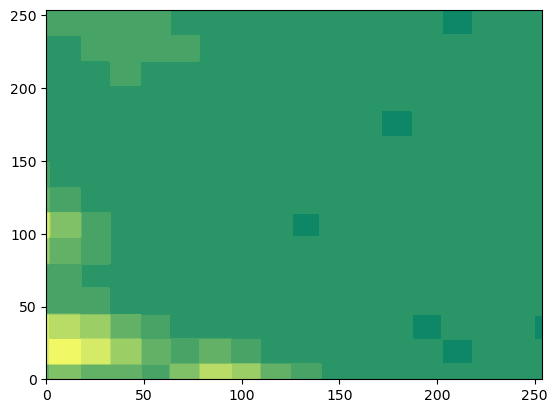

Label: 5.0
tensor(-0.9361)
tensor(-0.9982)
tensor(-0.9945)
0.0


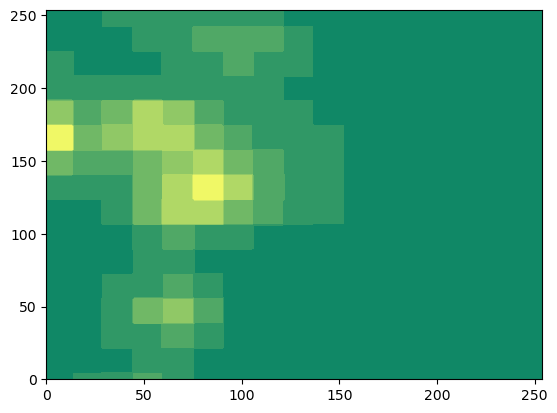

Label: 3.888888888888889
tensor(0.2037)
tensor(-0.9347)
tensor(-0.4411)
0.043521722414455975


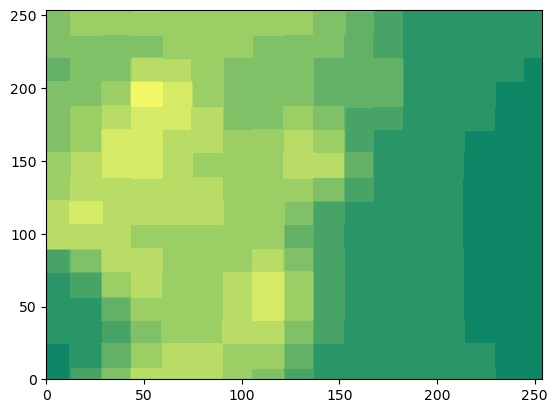

Label: 1.0
tensor(-0.3441)
tensor(-0.9740)
tensor(-0.9075)
0.0


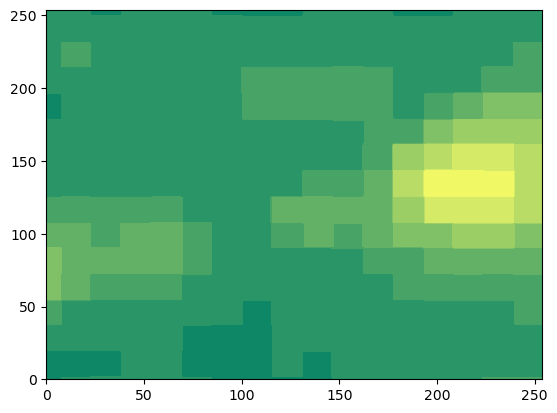

Label: 3.1818181818181817
tensor(-0.9648)
tensor(-0.9980)
tensor(-0.9935)
0.0


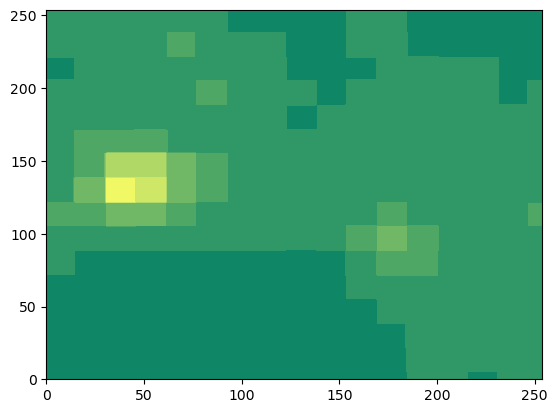

Label: 4.315789473684211
tensor(-0.8685)
tensor(-0.9959)
tensor(-0.9819)
0.0


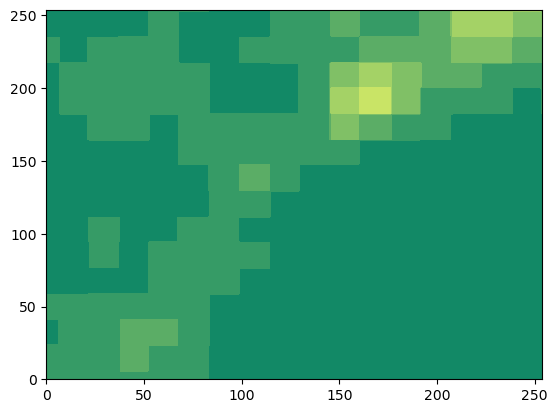

Label: 4.818181818181818
tensor(-0.9981)
tensor(-1.)
tensor(-0.9992)
0.0


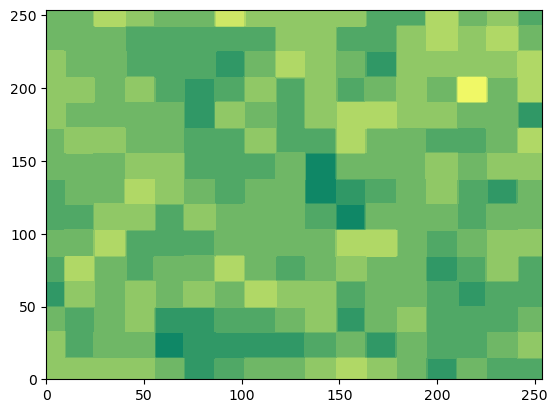

Label: 3.0
tensor(0.9213)
tensor(-0.7567)
tensor(-0.0337)
0.39161860822760475


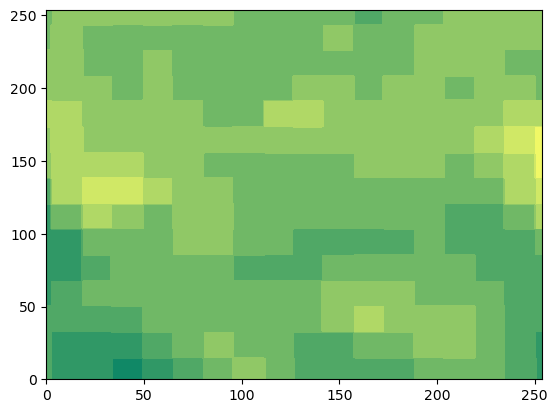

Label: 4.8
tensor(1.)
tensor(-0.9494)
tensor(-0.4639)
0.06266820453671665


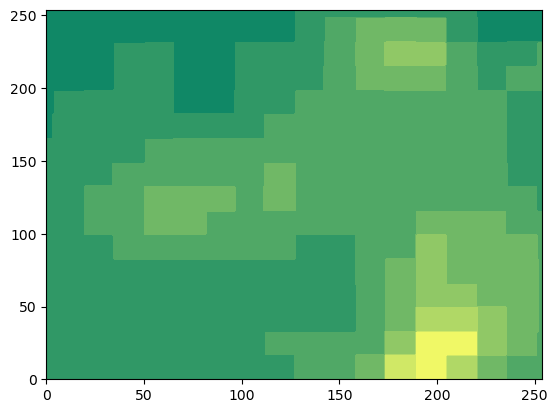

Label: 3.095238095238096
tensor(-0.9240)
tensor(-0.9849)
tensor(-0.9751)
0.0


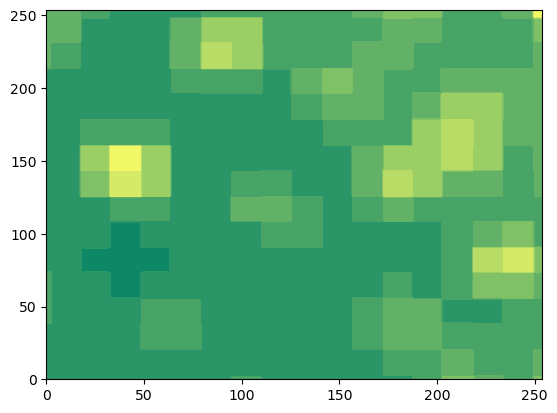

In [145]:
for i, img in enumerate(v_p):
    print(f"Label: {labs[i]}")
    print(torch.max(img.squeeze()))
    print(torch.min(img.squeeze()))
    print(torch.median(img.squeeze()))
    print(torch.numel(img[img > 0]) / (255*255))
    plt.contourf(img.squeeze(), cmap=plt.cm.summer)
    plt.show()

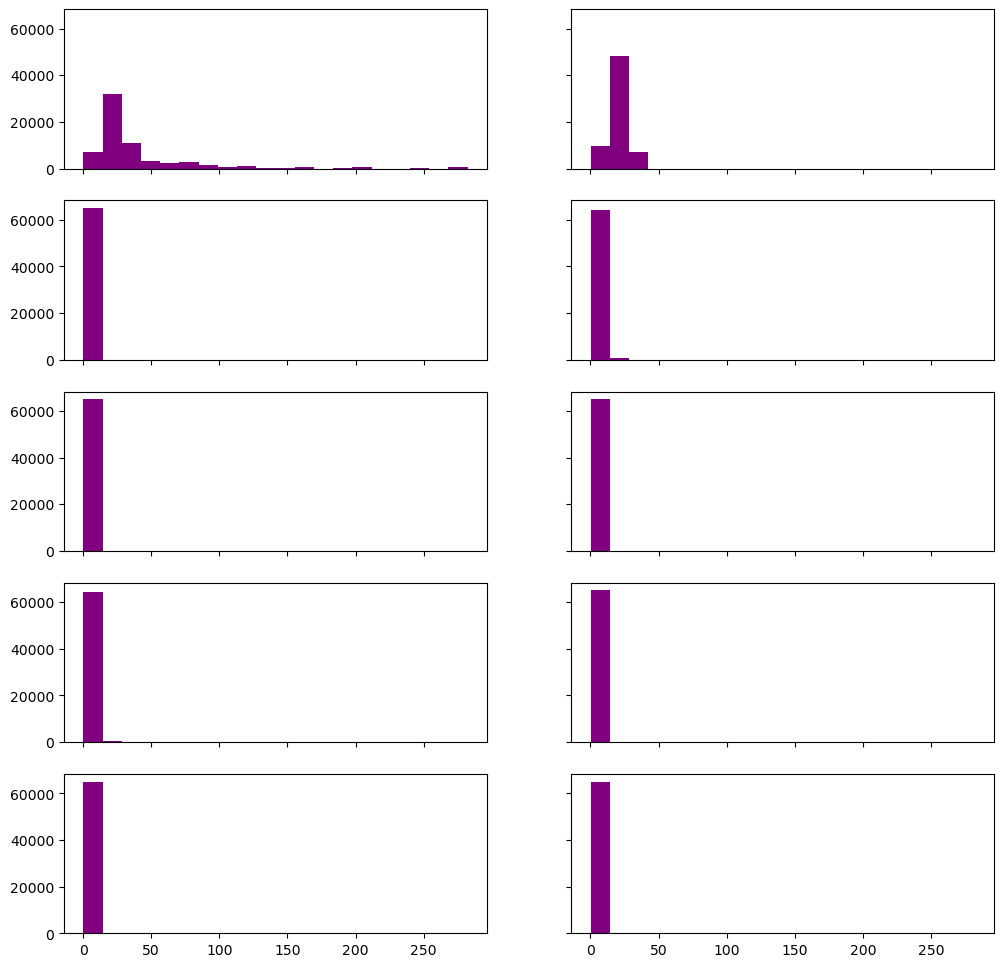

In [137]:
# !pip install earthpy
import earthpy.plot as ep

ep.hist(imgs)
plt.show()